### Model for 2 players only.

In [1]:
# 1. Start by loading all the csv files of 2 players in a dataframe
import pandas as pd
from pathlib import Path

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path structure in Google Drive
games_folder = Path("/content/drive/MyDrive/Colab Notebooks/DL2_model/2_games")

print("Checking folder:", games_folder)

#Load the Files

if not games_folder.exists():
    print("Error: Folder does not exist.")
else:
    csv_files = sorted(games_folder.glob("*.csv"))
    print(f"Found {len(csv_files)} CSV files")

    if len(csv_files) == 0:
        print("No csv files found in folder")
    else:
        dfs = [pd.read_csv(file) for file in csv_files]
        combined_df = pd.concat(dfs, ignore_index=True)

        print("Combined DataFrame shape:", combined_df.shape)
        display(combined_df.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Checking folder: /content/drive/MyDrive/Colab Notebooks/DL2_model/2_games
Found 3500 CSV files
Combined DataFrame shape: (203568, 403)


,game_id,num_players,turn_number,current_player,gems_board_white,gems_board_blue,gems_board_green,gems_board_red,gems_board_black,gems_board_gold,...,gem_take2_green,gem_take2_red,gem_take2_black,noble_selection,gems_removed_white,gems_removed_blue,gems_removed_green,gems_removed_red,gems_removed_black,gems_removed_gold
0,1,2,1,0,4,4,4,4,4,5,...,0.0,2.0,0.0,-1,0,0,0,0,0,0
1,1,2,1,1,4,4,4,2,4,5,...,NaN,NaN,NaN,-1,0,0,0,0,0,0
2,1,2,2,0,3,3,4,2,3,5,...,NaN,NaN,NaN,-1,0,0,0,0,0,0
3,1,2,2,1,2,2,3,2,3,5,...,NaN,NaN,NaN,-1,0,0,0,0,0,0
4,1,2,3,0,1,1,2,2,3,5,...,NaN,NaN,NaN,-1,0,0,0,0,0,0


### 1. Feature engineering

In Splendor, optimal decision-making requires understanding both the current game state and strategic relationships between resources cards, and opponents. The 285 engineered features capture three key dimensions: (1) observable game state (gems, visible cards, nobles), (2) player capabilities (resources, reductions, victory points), and (3) derived strategic signals (card affordability, proximity to nobles, relative advantages). By pre-computing these relationships and normalizing all values to [0,1], we simplify the learning task for our MLP baseline, allowing it to focus on pattern recognition rather than complex mathematical reasoning. This approach encodes domain expertise directly into the feature space.

In [2]:
# Dictionary to store all normalized features
normalized_features = {}

#Copy of the combined dataframe
df = combined_df.copy()
features_df = pd.DataFrame()

In [3]:
# 1. GLOBAL features for capturing temporal context and available resources on the board ==> 10 features

# 1.1 Turn number for temporal context (early/mid/late game) ==> 1 feature
normalized_features['turn_number'] = df["turn_number"] / df['turn_number'].max()

# 1.2. Gems on board for resource availability ==> 6 features
for color in ['white', 'blue', 'green', 'red', 'black', 'gold']:
    normalized_features[f'gems_board_{color}'] = df[f'gems_board_{color}'] / df[f'gems_board_{color}'].max()

# 1.3. Normalize for remaining cards on deck
# Helps to learn about the progress of the game and time the strategies ==> 3 features
normalized_features['deck_level1_remaining'] = df['deck_level1_remaining'] / df['deck_level1_remaining'].max()
normalized_features['deck_level2_remaining'] = df['deck_level2_remaining'] / df['deck_level2_remaining'].max()
normalized_features['deck_level3_remaining'] = df['deck_level3_remaining'] / df['deck_level3_remaining'].max()

In [4]:
# 2. VISIBLE CARDS ==> 12 cards x 7 features (each color) = 84 features
# Cards on the board represent immediate purchasing opportunities

# 2.1. Normalize for victory points and cost for each color
# The maximum for vp across all card is 5
# There are 12 cards in total

for i in range(12):
  normalized_features[f'card{i}_vp'] = df[f'card{i}_vp'] / 5.0
  normalized_features[f'card{i}_level'] = df[f'card{i}_level'] / 3.0 # Level (ordinal: 1, 2, 3 → represents difficulty/tier)
  for color in ['white', 'blue', 'green', 'red', 'black']:
    normalized_features[f'card{i}_cost_{color}'] = df[f'card{i}_cost_{color}'] / df[f'card{i}_cost_{color}'].max()

In [5]:
#3. NOBLES ==> 5 nobles x 6 features = 30 features
# Represent long-term strategic objectives
for i in range(5):
    # VP (always 3, but normalized for consistency)
    normalized_features[f'noble{i}_vp'] = df[f'noble{i}_vp'] / 3.0

    # Requirements (reduction bonuses needed)
    for color in ['white', 'blue', 'green', 'red', 'black']:
        normalized_features[f'noble{i}_req_{color}'] = df[f'noble{i}_req_{color}'] / df[f'noble{i}_req_{color}'].max()

In [6]:
# 4. PLAYER STATES (2 players × 42 features = 84 features)
# Captures resources, reductions, VP, and reserved cards for both players
for player_idx in range(2):
    # 4.1. Gems (immediate purchasing power)
    for color in ['white', 'blue', 'green', 'red', 'black', 'gold']:
        normalized_features[f'player{player_idx}_gems_{color}'] = df[f'player{player_idx}_gems_{color}'] / df[f'player{player_idx}_gems_{color}'].max()

    # 4.2. Permanent reductions (the "engine" - permanent discounts)
    for color in ['white', 'blue', 'green', 'red', 'black']:
        normalized_features[f'player{player_idx}_reduction_{color}'] = df[f'player{player_idx}_reduction_{color}'] / df[f'player{player_idx}_reduction_{color}'].max()

    # 4.3. Victory points (goal is 15)
    normalized_features[f'player{player_idx}_vp'] = df[f'player{player_idx}_vp'] / df[f'player{player_idx}_vp'].max()

    # 4.4. Position (0 or 1 - already binary)
    normalized_features[f'player{player_idx}_position'] = df[f'player{player_idx}_position']

    # 4.5. Reserved cards (hidden strategic advantage - max 3 per player)
    for reserve_idx in range(3):
        normalized_features[f'player{player_idx}_reserved{reserve_idx}_vp'] = df[f'player{player_idx}_reserved{reserve_idx}_vp'] / df[f'player{player_idx}_reserved{reserve_idx}_vp'].max()
        normalized_features[f'player{player_idx}_reserved{reserve_idx}_level'] = df[f'player{player_idx}_reserved{reserve_idx}_level'] / 3.0

        for color in ['white', 'blue', 'green', 'red', 'black']:
            normalized_features[f'player{player_idx}_reserved{reserve_idx}_cost_{color}'] = df[f'player{player_idx}_reserved{reserve_idx}_cost_{color}'] / df[f'player{player_idx}_reserved{reserve_idx}_cost_{color}'].max()

In [7]:
# 5. DERIVED STRATEGIC FEATURES
# Pre-computed relationships that help the MLP understand strategic situations
import numpy as np

#5.1 Affordability
# Question: "Can the active player buy this card RIGHT NOW with current resources?"
# Logic: For each card, check if (gems + reductions + gold) >= card cost

# extract current_player for fast indexing
current_player = df['current_player'].values

# Loop through each of the 12 visible cards
for card_idx in range(12):

    #1.Calculate total gold needed for PLAYER 0 to buy this card
    total_gold_p0 = np.zeros(len(df))  # Start with 0 gold needed per row

    for color in ['white', 'blue', 'green', 'red', 'black']:
        # Get card cost for this color (same for all rows)
        cost = df[f'card{card_idx}_cost_{color}'].values

        # Calculate what player 0 has available = gems + permanent reductions
        available_p0 = (df[f'player0_gems_{color}'].values +
                       df[f'player0_reduction_{color}'].values)

        # Calculate : how much is missing? (0 if already enough)
        shortfall_p0 = np.maximum(0, cost - available_p0)

        # Accumulate shortfall across all 5 colors
        total_gold_p0 += shortfall_p0

    # Check if player 0 has enough gold to cover all shortfalls
    can_afford_p0 = (total_gold_p0 <= df['player0_gems_gold'].values).astype(float)

    #Same logic for the other player

    # 2. Calculate total gold needed for PLAYER 1 to buy this card
    total_gold_p1 = np.zeros(len(df))  # Start with 0 gold needed per row

    for color in ['white', 'blue', 'green', 'red', 'black']:
        # Get card cost for this color
        cost = df[f'card{card_idx}_cost_{color}'].values

        # Calculate what player 1 has available
        available_p1 = (df[f'player1_gems_{color}'].values +
                       df[f'player1_reduction_{color}'].values)

        # Calculate shortfall for player 1
        shortfall_p1 = np.maximum(0, cost - available_p1)

        # Accumulate shortfall across all 5 colors
        total_gold_p1 += shortfall_p1

    # Check if player 1 has enough gold to cover all shortfalls
    can_afford_p1 = (total_gold_p1 <= df['player1_gems_gold'].values).astype(float)


    # 3. Select the right affordability based on whose turn it is
    # For each row: if current_player=0, use can_afford_p0, else use can_afford_p1
    normalized_features[f'can_afford_card{card_idx}'] = np.where(
        current_player == 0,  # Condition: is it player 0's turn?
        can_afford_p0,        # If yes, use player 0's affordability
        can_afford_p1         # If no, use player 1's affordability
    )

In [8]:
# 5.2 Distances to Nobles (25 features: 5 nobles × 5 colors)
# How many more reductions needed to attract each noble?

current_player = df['current_player'].values

# Loop through each of the 5 nobles
for noble_idx in range(5):

    # Loop through each color requirement
    for color in ['white', 'blue', 'green', 'red', 'black']:

        # 1.Get noble requirement for this color (same across all rows)
        required = df[f'noble{noble_idx}_req_{color}'].values

        # 2.Get reductions owned by each player
        owned_p0 = df[f'player0_reduction_{color}'].values
        owned_p1 = df[f'player1_reduction_{color}'].values

        # 3.Calculate distance for each player
        # Distance = how many more reductions needed (0 if already satisfied)
        distance_p0 = np.maximum(0, required - owned_p0)
        distance_p1 = np.maximum(0, required - owned_p1)

        # 4.Select based on whose turn it is
        # For each row: if current_player=0, use distance_p0, else use distance_p1
        distance_active = np.where(
            current_player == 0,  # Condition: is it player 0's turn?
            distance_p0,          # If yes, use player 0's distance
            distance_p1           # If no, use player 1's distance
        )

        # 5.Normalize by max requirement (4)
        normalized_features[f'distance_noble{noble_idx}_{color}'] = distance_active / 4.0

In [9]:
# 5.3 Relative advantages
# Compare active player vs opponent on some key metrics
# Relative VP

# Pre-extract current_player as numpy array for fast indexing
current_player = df['current_player'].values

# --- F3.1: RELATIVE VICTORY POINTS ---
# Who is winning? Positive = active player ahead, Negative = opponent ahead
vp_p0 = df['player0_vp'].values
vp_p1 = df['player1_vp'].values

# Calculate difference: active player VP - opponent VP
relative_vp = np.where(
    current_player == 0,     # If player 0's turn
    vp_p0 - vp_p1,          # Player 0 - Player 1
    vp_p1 - vp_p0           # Player 1 - Player 0
)
normalized_features['relative_vp'] = relative_vp / 15.0  # Normalize by winning VP

In [10]:
# 5.4 RELATIVE GEMS (5 colors)
# Who has more gems of each color?
for color in ['white', 'blue', 'green', 'red', 'black']:
    gems_p0 = df[f'player0_gems_{color}'].values
    gems_p1 = df[f'player1_gems_{color}'].values

    # Calculate difference: active player gems - opponent gems
    relative_gems = np.where(
        current_player == 0,     # If player 0's turn
        gems_p0 - gems_p1,      # Player 0 - Player 1
        gems_p1 - gems_p0       # Player 1 - Player 0
    )
    normalized_features[f'relative_gems_{color}'] = relative_gems / relative_gems.max() # Normalize by max gems


In [11]:
# 5.5 RELATIVE REDUCTIONS (5 colors) ---
# Who has a stronger "engine" (more permanent bonuses)?
for color in ['white', 'blue', 'green', 'red', 'black']:
    reduction_p0 = df[f'player0_reduction_{color}'].values
    reduction_p1 = df[f'player1_reduction_{color}'].values

    # Calculate difference: active player reductions - opponent reductions
    relative_reductions = np.where(
        current_player == 0,     # If player 0's turn
        reduction_p0 - reduction_p1,  # Player 0 - Player 1
        reduction_p1 - reduction_p0   # Player 1 - Player 0
    )
    normalized_features[f'relative_reduction_{color}'] = relative_reductions / relative_reductions.max() # Normalize by typical max


In [12]:
# 5.6 GEM DIVERSITY
# How many different gem colors does the active player have?
# Get gems for each player and color
gems_p0_white = df['player0_gems_white'].values
gems_p0_blue = df['player0_gems_blue'].values
gems_p0_green = df['player0_gems_green'].values
gems_p0_red = df['player0_gems_red'].values
gems_p0_black = df['player0_gems_black'].values

gems_p1_white = df['player1_gems_white'].values
gems_p1_blue = df['player1_gems_blue'].values
gems_p1_green = df['player1_gems_green'].values
gems_p1_red = df['player1_gems_red'].values
gems_p1_black = df['player1_gems_black'].values

# Count how many colors each player has (binary: has gems or not)
diversity_p0 = ((gems_p0_white > 0).astype(int) +
                (gems_p0_blue > 0).astype(int) +
                (gems_p0_green > 0).astype(int) +
                (gems_p0_red > 0).astype(int) +
                (gems_p0_black > 0).astype(int))

diversity_p1 = ((gems_p1_white > 0).astype(int) +
                (gems_p1_blue > 0).astype(int) +
                (gems_p1_green > 0).astype(int) +
                (gems_p1_red > 0).astype(int) +
                (gems_p1_black > 0).astype(int))

# Select based on current player and normalize by max (5 colors)
gem_diversity = np.where(
    current_player == 0,
    diversity_p0,
    diversity_p1
) / 5.0

normalized_features['gem_diversity'] = gem_diversity

In [13]:
# 5.7 Total gems
# How many total gems does the active player have? (approaching 10 = must buy/reserve soon)
total_gems_p0 = (gems_p0_white + gems_p0_blue + gems_p0_green +
                 gems_p0_red + gems_p0_black + df['player0_gems_gold'].values)

total_gems_p1 = (gems_p1_white + gems_p1_blue + gems_p1_green +
                 gems_p1_red + gems_p1_black + df['player1_gems_gold'].values)

# Select based on current player and normalize by max (10 gems)
total_gems = np.where(
    current_player == 0,
    total_gems_p0,
    total_gems_p1
) / 10.0

normalized_features['total_gems'] = total_gems

In [14]:
# 5.8 Total reduction
# How powerful is the active player (more reductions = easier to buy cards)
total_reductions_p0 = (df['player0_reduction_white'].values +
                       df['player0_reduction_blue'].values +
                       df['player0_reduction_green'].values +
                       df['player0_reduction_red'].values +
                       df['player0_reduction_black'].values)

total_reductions_p1 = (df['player1_reduction_white'].values +
                       df['player1_reduction_blue'].values +
                       df['player1_reduction_green'].values +
                       df['player1_reduction_red'].values +
                       df['player1_reduction_black'].values)

# Select based on current player and normalize by theoretical max of 35
total_reductions = np.where(
    current_player == 0,
    total_reductions_p0,
    total_reductions_p1
) / 24.0

normalized_features['total_reductions'] = total_reductions

In [15]:
#6. Concatenate all features to avoid fragmentation of dataframe
# From dictionary to dataframe

features_df = pd.DataFrame(normalized_features)

In [16]:
# Remove redundant player0_position and player1_position from the dataframe
cols_to_remove = ["player0_position", "player1_position"]
features_df = features_df.drop(columns=cols_to_remove)

In [17]:
# Download first 57 rows as CSV to make some manual spotchecks
# features_df.head(57).to_csv('first_57_rows2.csv', index=False)

# from google.colab import files
# files.download('first_57_rows2.csv')

#### 2. Data cleaning

In [18]:
# 2.1 Delete the empty columns in the features_df
features_df = features_df.dropna(axis=1)

In [19]:
# 2.2 Find the final number of features
nb_features = features_df.columns.size
print("Number of features:", nb_features)

Number of features: 144


In [20]:
# 2.3 Define the Target Variable (Y): Extract the action the current player took (the label your model will try to predict) from the original combined DataFrame.
# Y is action_type in the df
Y = df["action_type"]

In [21]:
# 2.4 Print shape of target column and feature dataframe
rows, cols = features_df.shape

print("Number of rows in feature dataframe:", rows)
print("Number of columns in feature dataframe:", cols)
print('\n')
print("Number of rows in the target column:", Y.size)

Number of rows in feature dataframe: 203568
Number of columns in feature dataframe: 144


Number of rows in the target column: 203568


In [22]:
# 2.5 Combine the target column with the feature dataframe
Y = Y.rename("target")
final_df = pd.concat([features_df, Y], axis=1)

#### 3. Split the dataset into train and test dataset



In [23]:
from sklearn.model_selection import train_test_split

# 1. Separate features (X) and target (y)
X = final_df.drop(columns=["target"])
y = final_df["target"]

# 2. First split: 70% train, 30% temp (which will become 15% val + 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,           # 30% for temp (val + test)
    random_state=42,         # reproducibility
    stratify=y               # keeps class distribution balanced
)

# 3. Second split: split the 30% temp into 15% val and 15% test (50-50 split of temp)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,           # 50% of temp = 15% of total
    random_state=42,         # reproducibility
    stratify=y_temp          # keeps class distribution balanced
)

print("Train set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (142497, 144) (142497,)
Validation set shape: (30535, 144) (30535,)
Test set shape: (30536, 144) (30536,)


In [24]:
# 3. Print the resulting sizes to verify the split
print(f"Original dataset size: {len(X)} rows")
print("-" * 40)
print(f"Training features (X_train) size:   {X_train.shape}")
print(f"Validation features (X_val) size:  {X_val.shape}")
print(f"Testing features (X_test) size:    {X_test.shape}")
print("-" * 40)
print(f"Training target (y_train) size:    {y_train.shape}")
print(f"Validation target (y_val) size:   {y_val.shape}")
print(f"Testing target (y_test) size:     {y_test.shape}")

# 4. Verify the class balance
print("\nClass distribution in y_train:")
print(y_train.value_counts(normalize=True))

print("\nClass distribution in y_val:")
print(y_val.value_counts(normalize=True))

print("\nClass distribution in y_test:")
print(y_test.value_counts(normalize=True))


Original dataset size: 203568 rows
----------------------------------------
Training features (X_train) size:   (142497, 144)
Validation features (X_val) size:  (30535, 144)
Testing features (X_test) size:    (30536, 144)
----------------------------------------
Training target (y_train) size:    (142497,)
Validation target (y_val) size:   (30535,)
Testing target (y_test) size:     (30536,)

Class distribution in y_train:
target
build            0.518193
take 3 tokens    0.454838
take 2 tokens    0.026176
reserve          0.000793
Name: proportion, dtype: float64

Class distribution in y_val:
target
build            0.518192
take 3 tokens    0.454855
take 2 tokens    0.026167
reserve          0.000786
Name: proportion, dtype: float64

Class distribution in y_test:
target
build            0.518208
take 3 tokens    0.454840
take 2 tokens    0.026166
reserve          0.000786
Name: proportion, dtype: float64


#### 4. Address class imbalance
>With reserve at only 0.08%, use class weights in your loss function (inversely proportional to class frequencies) to prevent the model from ignoring this rare but strategically important action.

### 5 . Training the MLP model

In [25]:
# Importing the right libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# 1. Convert to PyTorch tensors
# Convert features
X_train_tensor = torch.FloatTensor(X_train.values)
X_val_tensor   = torch.FloatTensor(X_val.values)
X_test_tensor  = torch.FloatTensor(X_test.values)

# Convert target
# Convert target labels (strings) to class indices
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_indices = label_encoder.fit_transform(y_train)   # Fit on train
y_val_indices   = label_encoder.transform(y_val)         # Transform validation
y_test_indices  = label_encoder.transform(y_test)        # Transform test

# Convert to PyTorch tensors
y_train_tensor = torch.LongTensor(y_train_indices)
y_val_tensor   = torch.LongTensor(y_val_indices)
y_test_tensor  = torch.LongTensor(y_test_indices)

In [26]:
# 1.1 Verify encoding
print("Label encoding:")
for idx, label in enumerate(label_encoder.classes_):
    print(f"  {idx}: {label}")

Label encoding:
  0: build
  1: reserve
  2: take 2 tokens
  3: take 3 tokens


In [27]:
# 2. Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

# 3. Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [28]:
# 3. Compute the class weights (for imbalanced classes)
# This time we do it before training with the right label encoding

# Label encoding:
#   0: build
#   1: reserve
#   2: take 2 tokens
#   3: take 3 tokens

from sklearn.utils.class_weight import compute_class_weight

classes = np.array([0, 1, 2, 3])

# Compute weights based on training set only
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train_indices
)
class_weights_tensor = torch.FloatTensor(class_weights)

print("Class weights:")
class_names = ['build', 'reserve', 'take 2 tokens', 'take 3 tokens']
for cls_name, weight in zip(class_names, class_weights):
    print(f"  {cls_name}: {weight:.2f}")

Class weights:
  build: 0.48
  reserve: 315.26
  take 2 tokens: 9.55
  take 3 tokens: 0.55


In [30]:
# 4. Define the MLP Model

class SplendorMLP(nn.Module):
    def __init__(self, input_dim, hidden1, hidden2, num_classes, dropout):
        super(SplendorMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.bn1 = nn.BatchNorm1d(hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.bn2 = nn.BatchNorm1d(hidden2)
        self.fc3 = nn.Linear(hidden2, num_classes)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)  # No softmax here - CrossEntropyLoss handles it
        return x

# Instantiate model
model = SplendorMLP(input_dim=144, hidden1=256, hidden2=128, num_classes=4, dropout=0.3)

In [31]:
#5. Define the loss, the optimizr and the scheduler

# CrossEntropyLoss is used for multi-class classification.
# The 'weight' argument lets us handle class imbalance by giving rare classes more importance.
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Adam optimizer is chosen for its adaptive learning rate and efficiency.
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Scheduler automatically reduces the learning rate when validation loss stops improving.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [33]:
#6. Training loop (First attempt, no GPU)

num_epochs = 100
best_val_loss = float('inf') # Track best validation loss
patience_counter = 0
early_stop_patience = 15

print("\nStarting training...")
print("="*80)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for X_batch, y_batch in train_loader: # Iterate through mini-batches of data
        # Forward pass
        outputs = model(X_batch) # Get model predictions (logits) for this batch
        loss = criterion(outputs, y_batch) # Calculate loss between predictions and true labels

        # Backward pass
        optimizer.zero_grad() # Clear gradients from previous iteration (prevents accumulation)
        loss.backward() # Compute gradients via backpropagation
        optimizer.step() # Update model weights using computed gradients

        # Track metrics
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += y_batch.size(0)
        train_correct += (predicted == y_batch).sum().item() # Count correct predictions

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total

    #==============================================================================
    # Validation phase
    model.eval() # Set model to evaluation mode (disables dropout, fixes batchnorm)
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad(): # Disable gradient computation (saves memory and speeds up inference)
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += y_batch.size(0)
            val_correct  += (predicted == y_batch).sum().item() # Count correct predictions

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total

    # Learning rate scheduling
    scheduler.step(avg_val_loss) # Reduce learning rate if valid loss plateaus

   # -------------------
    # Print progress
    # -------------------
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%")
        print(f"  Val Loss:   {avg_val_loss:.4f}, Val Acc:   {val_accuracy:.2f}%")

    # -------------------
    # Early stopping based on validation loss
    # -------------------
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_splendor_model.pth')  # Save best model
    else:
        patience_counter += 1

    if patience_counter >= early_stop_patience:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

print("\n" + "="*80)
print("Training complete!")
print(f"Best validation loss: {best_val_loss:.4f}")


Starting training...
Epoch [10/100]
  Train Loss: 0.6718, Train Acc: 63.78%
  Val Loss:   0.6845, Val Acc:   65.79%
Epoch [20/100]
  Train Loss: 0.5931, Train Acc: 67.15%
  Val Loss:   0.7293, Val Acc:   66.84%

Early stopping triggered at epoch 27

Training complete!
Best validation loss: 0.6708


In [34]:
# # Final Test Evaluation - no GPU
# PER-CLASS METRICS

from sklearn.metrics import classification_report, confusion_matrix

# Get predictions
model.load_state_dict(torch.load('best_splendor_model.pth'))
model.eval()

all_predictions = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.numpy())
        all_targets.extend(y_batch.numpy())

all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

# Get class names
class_names = label_encoder.classes_

# Print classification report
print("="*80)
print("CLASSIFICATION REPORT")
print("="*80)
print(classification_report(all_targets, all_predictions, target_names=class_names))

# Print confusion matrix
print("\n" + "="*80)
print("CONFUSION MATRIX")
print("="*80)
cm = confusion_matrix(all_targets, all_predictions)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
print(cm_df)

# Check prediction distribution
print("\n" + "="*80)
print("PREDICTION vs ACTUAL DISTRIBUTION")
print("="*80)
for i, cls_name in enumerate(class_names):
    pred_count = (all_predictions == i).sum()
    actual_count = (all_targets == i).sum()
    print(f"{cls_name:20s} - Predicted: {pred_count:5d}, Actual: {actual_count:5d}")

CLASSIFICATION REPORT
               precision    recall  f1-score   support

        build       0.77      0.70      0.73     15824
      reserve       0.04      0.83      0.08        24
take 2 tokens       0.11      0.83      0.20       799
take 3 tokens       0.75      0.54      0.63     13889

     accuracy                           0.63     30536
    macro avg       0.42      0.73      0.41     30536
 weighted avg       0.75      0.63      0.67     30536


CONFUSION MATRIX
               build  reserve  take 2 tokens  take 3 tokens
build          11038      359           2041           2386
reserve            4       20              0              0
take 2 tokens     52        0            667             80
take 3 tokens   3164      121           3111           7493

PREDICTION vs ACTUAL DISTRIBUTION
build                - Predicted: 14258, Actual: 15824
reserve              - Predicted:   500, Actual:    24
take 2 tokens        - Predicted:  5819, Actual:   799
take 3 tokens    

Architecture 1: 256 → 128 → 4, dropout 0.3
Accuracy: 63%

Macro F1: 0.41 (weighted F1: 0.67)

Strengths:

Good performance on majority classes (build and take 3 tokens).

Recall for rare classes (reserve, take 2 tokens) is surprisingly high (0.83), meaning the model often flags them.

Weaknesses:

Precision for rare classes is extremely low (0.04 and 0.11), leading to floods of false positives.

Over-prediction: e.g., reserve predicted 500 times vs only 24 actual.

Interpretation: The larger model memorizes patterns and aggressively predicts minority classes, but without precision. Accuracy looks decent because majority classes dominate.

The model achieves 63% accuracy but this metric is misleading due to severe class imbalance issues. While it handles the dominant "build" and "take 3 tokens" classes reasonably well (77% and 75% precision), it catastrophically fails on minority classes.

The most critical failure is "reserve" (0.08% of data), which the model over-predicts by 21× (500 predictions vs 24 actual), achieving only 4% precision despite 83% recall. Similarly, "take 2 tokens" is over-predicted by 7.3× (5,819 vs 799 actual) with just 11% precision. These extreme over-predictions create floods of false positives that would make the model unusable in practice.

The confusion matrix shows systematic errors: 3,164 "take 3 tokens" misclassified as "build" and 3,111 as "take 2 tokens." The model is simultaneously biased toward common classes when uncertain, yet over-triggers on rare classes. The gap between macro F1 (0.41) and weighted F1 (0.67) confirms that minority class failures are masked by dominant class performance, making the 63% accuracy fundamentally unreliable as a quality metric.

#7. Training loop with MLP (Second attempt)`

Key Changes:

1. Capped weights to 10.0 - prevents "reserve" (315→10) from dominating
2. Smaller model (256→256 becomes 128→64) - less overfitting
3. Higher dropout (0.3→0.4) - better generalization
4. L2 regularization - penalizes large weights
5. F1-score for early stopping - better metric for imbalanced data
6. Better monitoring - shows F1-score during training

In [35]:
# Check and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: Tesla T4
GPU Memory: 15.83 GB


In [36]:
# 1. COMPUTE CLASS WEIGHTS - WITH CAPPING TO PREVENT EXTREMES

classes = np.array([0, 1, 2, 3])
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train_indices
)

# CAP THE WEIGHTS: Prevent extreme values from dominating
class_weights_capped = np.clip(class_weights, 0.5, 10.0)

class_weights_tensor = torch.FloatTensor(class_weights_capped)

# Move class weights to GPU (for criterion)
class_weights_tensor = class_weights_tensor.to(device)

print("Original vs Capped Class Weights:")
class_names = label_encoder.classes_
for cls_name, orig, capped in zip(class_names, class_weights, class_weights_capped):
    print(f"  {cls_name:20s}: {orig:7.2f} -> {capped:5.2f}")

Original vs Capped Class Weights:
  build               :    0.48 ->  0.50
  reserve             :  315.26 -> 10.00
  take 2 tokens       :    9.55 ->  9.55
  take 3 tokens       :    0.55 ->  0.55


In [37]:
# After moving to GPU
class_weights_tensor = class_weights_tensor.to('cuda')

# Check device
print(class_weights_tensor.device)

cuda:0


In [41]:
# 3. Smaller model with higher dropout
model_v2 = SplendorMLP(input_dim=144, hidden1=128, hidden2=64, num_classes=4, dropout=0.4)
# Move model to GPU
model_v2 = model_v2.to(device)

In [42]:
print(f"\nModel architecture: 144 → 128 → 64 → 4")
print(f"Total parameters: {sum(p.numel() for p in model_v2.parameters()):,}")


Model architecture: 144 → 128 → 64 → 4
Total parameters: 27,460


In [43]:
#4. Define Loss, Optimizer with L2 Regularization and scheduler
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model_v2.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [44]:
# 5. TRAINING LOOP WITH GPU SUPPORT AND VALIDATION SET

num_epochs = 100
best_val_loss = float('inf')
best_val_f1 = 0.0
patience_counter = 0
early_stop_patience = 15

print("\nStarting training...")
print("="*80)

for epoch in range(num_epochs):
    # Training phase
    model_v2.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for X_batch, y_batch in train_loader:
        # Move batch to GPU
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model_v2(X_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += y_batch.size(0)
        train_correct += (predicted == y_batch).sum().item()

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total

    # Validation phase
    model_v2.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_val_preds = []
    all_val_targets = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            # Move batch to GPU
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += y_batch.size(0)
            val_correct += (predicted == y_batch).sum().item()

            # Move predictions back to CPU for sklearn
            all_val_preds.extend(predicted.cpu().numpy())
            all_val_targets.extend(y_batch.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total

    # Calculate macro F1-score
    from sklearn.metrics import f1_score
    val_f1_macro = f1_score(all_val_targets, all_val_preds, average='macro')

    scheduler.step(avg_val_loss)

    # Print progress every 5 epochs
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%")
        print(f"  Val Loss:   {avg_val_loss:.4f}, Val Acc:   {val_accuracy:.2f}%, F1: {val_f1_macro:.4f}")

    # Early stopping based on validation F1
    if val_f1_macro > best_val_f1:
        best_val_f1 = val_f1_macro
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_splendor_model_v2.pth')
        print(f"  ✓ New best Val F1: {val_f1_macro:.4f} (saved)")
    else:
        patience_counter += 1

    if patience_counter >= early_stop_patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

print("\n" + "="*80)
print("Training complete!")
print(f"Best validation F1: {best_val_f1:.4f}")
print(f"Best validation loss: {best_val_loss:.4f}")


Starting training...
  ✓ New best Val F1: 0.1902 (saved)
  ✓ New best Val F1: 0.1933 (saved)
Epoch [5/100]
  Train Loss: 0.7831, Train Acc: 61.41%
  Val Loss:   1.4557, Val Acc:   30.54%, F1: 0.1925
  ✓ New best Val F1: 0.1947 (saved)
Epoch [10/100]
  Train Loss: 0.7155, Train Acc: 62.67%
  Val Loss:   1.4497, Val Acc:   30.57%, F1: 0.1942
Epoch [15/100]
  Train Loss: 0.6713, Train Acc: 63.90%
  Val Loss:   1.4581, Val Acc:   30.37%, F1: 0.1921
Epoch [20/100]
  Train Loss: 0.6462, Train Acc: 64.39%
  Val Loss:   1.4620, Val Acc:   30.33%, F1: 0.1921

Early stopping at epoch 23

Training complete!
Best validation F1: 0.1947
Best validation loss: 1.4547


In [46]:
# Final evaluation on test set
print("\n" + "="*80)
print("Evaluating on test set...")
model_v2.load_state_dict(torch.load('best_splendor_model_v2.pth'))
model_v2.eval()

test_loss = 0.0
test_correct = 0
test_total = 0
all_test_preds = []
all_test_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model_v2(X_batch)
        loss = criterion(outputs, y_batch)

        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_total += y_batch.size(0)
        test_correct += (predicted == y_batch).sum().item()

        all_test_preds.extend(predicted.cpu().numpy())
        all_test_targets.extend(y_batch.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * test_correct / test_total

# Import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import numpy as np

# Calculate various metrics
test_f1_macro = f1_score(all_test_targets, all_test_preds, average='macro')
test_f1_weighted = f1_score(all_test_targets, all_test_preds, average='weighted')
test_precision_macro = precision_score(all_test_targets, all_test_preds, average='macro')
test_recall_macro = recall_score(all_test_targets, all_test_preds, average='macro')

print(f"\nTest Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"\nMacro Metrics:")
print(f"  Precision: {test_precision_macro:.4f}")
print(f"  Recall:    {test_recall_macro:.4f}")
print(f"  F1-Score:  {test_f1_macro:.4f}")
print(f"\nWeighted F1-Score: {test_f1_weighted:.4f}")

# Classification report
print("\n" + "="*80)
print("CLASSIFICATION REPORT")
print("="*80)
class_names = ['build', 'reserve', 'take 2 tokens', 'take 3 tokens']
print(classification_report(all_test_targets, all_test_preds,
                          target_names=class_names,
                          digits=2))

# Confusion matrix
print("="*80)
print("CONFUSION MATRIX")
print("="*80)
cm = confusion_matrix(all_test_targets, all_test_preds)
print(f"{'':>20}", end='')
for name in class_names:
    print(f"{name:>15}", end='')
print()
for i, name in enumerate(class_names):
    print(f"{name:>20}", end='')
    for j in range(len(class_names)):
        print(f"{cm[i][j]:>15}", end='')
    print()

# Prediction vs Actual distribution
print("\n" + "="*80)
print("PREDICTION vs ACTUAL DISTRIBUTION")
print("="*80)
unique_actual, counts_actual = np.unique(all_test_targets, return_counts=True)
unique_pred, counts_pred = np.unique(all_test_preds, return_counts=True)

# Create dict for easy lookup
pred_dict = dict(zip(unique_pred, counts_pred))

for i, name in enumerate(class_names):
    actual_count = counts_actual[i] if i < len(counts_actual) else 0
    pred_count = pred_dict.get(i, 0)
    print(f"{name:>20} - Predicted: {pred_count:>5}, Actual: {actual_count:>5}")

print("="*80)


Evaluating on test set...

Test Loss: 1.4118
Test Accuracy: 31.60%

Macro Metrics:
  Precision: 0.2205
  Recall:    0.2088
  F1-Score:  0.1877

Weighted F1-Score: 0.3460

CLASSIFICATION REPORT
               precision    recall  f1-score   support

        build       0.43      0.20      0.27     15824
      reserve       0.00      0.08      0.00        24
take 2 tokens       0.02      0.09      0.03       799
take 3 tokens       0.44      0.46      0.45     13889

     accuracy                           0.32     30536
    macro avg       0.22      0.21      0.19     30536
 weighted avg       0.42      0.32      0.35     30536

CONFUSION MATRIX
                              build        reserve  take 2 tokens  take 3 tokens
               build           3140           2232           2558           7894
             reserve              3              2              7             12
       take 2 tokens            302            103             72            322
       take 3 tokens  

Architecture 2: 128 → 64 → 4, dropout 0.4
Accuracy: 31.6%

Macro F1: 0.19 (weighted F1: 0.35)

Strengths:

More balanced predictions across classes (less extreme bias toward majority).

Slightly better recall for take 3 tokens (0.46 vs 0.54 previously).

Weaknesses:

Overall accuracy collapsed (from 63% → 32%).

Precision and recall for rare classes dropped to near zero.

Severe misclassification: reserve predicted 4,201 times vs only 24 actual.

Interpretation: The smaller, regularized model underfits — it lost the ability to capture strong patterns, leading to poor accuracy and weak minority class handling.

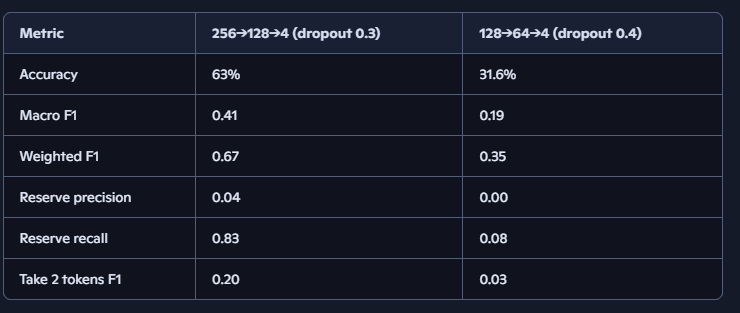![image.png]()

The larger model (256→128) performs better overall, but suffers from false positives on rare classes.

The smaller model (128→64) is too constrained and underfits, leading to poor accuracy and collapse in minority class performance.

Accuracy alone is misleading — macro F1 shows both models fail to handle imbalance well.

## Focal Loss implementation

- Focus learning on hard-to-classify examples while being much less aggressive than inverse frequency weighting, preventing the massive overprediction. It avoids exploding gradients and massive overprediction of rare classes.

- Oversampling for only the two minority classes (reserve and take 2 tokens) by duplicating them 3-5x in the training set. This gives the model more exposure to rare patterns without distorting the distribution too much.

In [61]:
#1. Define Focal Loss class and calculate effective class weights
# Focal Loss modifies CrossEntropyLoss by adding a focusing term

import torch.nn.functional as F
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        return focal_loss

In [51]:
#3. Oversample minority classes (reserve 5x, take 2 tokens 3x) to give the model more exposure without extreme weight changes
def get_effective_weights(class_counts, beta=0.999):
    effective_num = 1.0 - np.power(beta, class_counts)
    weights = (1.0 - beta) / effective_num
    weights = weights / weights.sum() * len(weights)
    return weights

# Get counts for each class using your y_train_indices
class_counts = np.array([
    (y_train_indices == 0).sum(),  # build
    (y_train_indices == 1).sum(),  # reserve
    (y_train_indices == 2).sum(),  # take 2 tokens
    (y_train_indices == 3).sum()   # take 3 tokens
])

In [53]:
print("Class counts in training set:")
for i, label in enumerate(label_encoder.classes_):
    print(f"  {i}: {label:20} {class_counts[i]:6d} samples")

Class counts in training set:
  0: build                 73841 samples
  1: reserve                 113 samples
  2: take 2 tokens          3730 samples
  3: take 3 tokens         64813 samples


In [54]:
# Calculate weights with beta=0.999
class_weights = get_effective_weights(class_counts, beta=0.999)
class_weights_tensor = torch.FloatTensor(class_weights).to(device)

print("\nClass weights (effective number method):")
for i, label in enumerate(label_encoder.classes_):
    print(f"  {i}: {label:20} weight: {class_weights[i]:.4f}")


Class weights (effective number method):
  0: build                weight: 0.3231
  1: reserve              weight: 3.0227
  2: take 2 tokens        weight: 0.3311
  3: take 3 tokens        weight: 0.3231


### Oversample Minority Classes

In [55]:
# Convert tensors back to numpy for oversampling
X_train_np = X_train_tensor.cpu().numpy()
y_train_np = y_train_tensor.cpu().numpy()

X_train_oversampled = X_train_np.copy()
y_train_oversampled = y_train_np.copy()

In [56]:
# Oversample reserve class (class 1) - duplicate 5x
reserve_indices = np.where(y_train_np == 1)[0]
print(f"Found {len(reserve_indices)} reserve samples, duplicating 5x...")
for _ in range(4):  # 4 more times = 5x total
    X_train_oversampled = np.vstack([X_train_oversampled, X_train_np[reserve_indices]])
    y_train_oversampled = np.concatenate([y_train_oversampled, y_train_np[reserve_indices]])


Found 113 reserve samples, duplicating 5x...


In [57]:
# Oversample take 2 tokens (class 2) - duplicate 3x
take2_indices = np.where(y_train_np == 2)[0]
print(f"Found {len(take2_indices)} take 2 tokens samples, duplicating 3x...")
for _ in range(2):  # 2 more times = 3x total
    X_train_oversampled = np.vstack([X_train_oversampled, X_train_np[take2_indices]])
    y_train_oversampled = np.concatenate([y_train_oversampled, y_train_np[take2_indices]])

Found 3730 take 2 tokens samples, duplicating 3x...


In [58]:
print(f"\nOriginal training set: {len(y_train_np)} samples")
print(f"Oversampled training set: {len(y_train_oversampled)} samples")
print(f"Increase: {len(y_train_oversampled) - len(y_train_np)} samples")


Original training set: 142497 samples
Oversampled training set: 150409 samples
Increase: 7912 samples


In [59]:
print("\nNew class distribution:")
for i, label in enumerate(label_encoder.classes_):
    count = (y_train_oversampled == i).sum()
    pct = 100 * count / len(y_train_oversampled)
    print(f"  {i}: {label:20} {count:6d} ({pct:5.2f}%)")


New class distribution:
  0: build                 73841 (49.09%)
  1: reserve                 565 ( 0.38%)
  2: take 2 tokens         11190 ( 7.44%)
  3: take 3 tokens         64813 (43.09%)


In [60]:
# Create new dataset with oversampled data
train_dataset_oversampled = TensorDataset(
    torch.FloatTensor(X_train_oversampled),
    torch.LongTensor(y_train_oversampled)
)

train_loader_oversampled = DataLoader(
    train_dataset_oversampled,
    batch_size=256,
    shuffle=True
)

print(f"\nNew train loader created with {len(train_loader_oversampled)} batches")


New train loader created with 588 batches


## Initialize Model with Focal Loss

In [62]:
# Instantiate model with my architecture
model_focal = SplendorMLP(
    input_dim=144,
    hidden1=256,
    hidden2=128,
    num_classes=4,
    dropout=0.3
).to(device)

In [63]:
# Initialize Focal Loss with gamma=1.5 and class weights
criterion_focal = FocalLoss(alpha=class_weights_tensor, gamma=1.5)

In [64]:
# Optimizer
optimizer_focal = optim.AdamW(
    model_focal.parameters(),
    lr=0.001,
    weight_decay=0.01
)

In [66]:
# Learning rate scheduler
scheduler_focal = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_focal,
    mode='max',
    factor=0.5,
    patience=5
)

In [67]:
print("Model initialized with Focal Loss")
print(f"  Architecture: 144 -> 256 -> 128 -> 4")
print(f"  Gamma: 1.5")
print(f"  Dropout: 0.3")
print(f"  Using oversampled training data: {len(y_train_oversampled):,} samples")
print(f"  Model parameters: {sum(p.numel() for p in model_focal.parameters()):,}")

Model initialized with Focal Loss
  Architecture: 144 -> 256 -> 128 -> 4
  Gamma: 1.5
  Dropout: 0.3
  Using oversampled training data: 150,409 samples
  Model parameters: 71,300


## Training Loop with validation set

In [69]:
# ============================================================================
#Training Loop with Focal Loss (GPU)
# ============================================================================
num_epochs = 50
best_val_f1 = 0.0
patience_counter = 0
early_stop_patience = 20

train_losses = []
val_f1_scores = []
val_losses = []

print("Starting training...")
print(f"Device: {device}")
print(f"Epochs: {num_epochs}")
print(f"Batch size: 256")
print(f"Early stopping patience: {early_stop_patience}")
print("="*80)

for epoch in range(num_epochs):
    # ==================== Training Phase ====================
    model_focal.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for X_batch, y_batch in train_loader_oversampled:
        # Move to GPU
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward pass
        optimizer_focal.zero_grad()
        outputs = model_focal(X_batch)
        loss = criterion_focal(outputs, y_batch)

        # Backward pass
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model_focal.parameters(), max_norm=1.0)

        # Update weights
        optimizer_focal.step()

        # Track metrics
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += y_batch.size(0)
        train_correct += (predicted == y_batch).sum().item()

    avg_train_loss = train_loss / len(train_loader_oversampled)
    train_accuracy = 100 * train_correct / train_total
    train_losses.append(avg_train_loss)

    # ==================== Validation Phase ====================
    model_focal.eval()
    val_loss = 0.0
    val_preds = []
    val_targets = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            # Move to GPU
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # Forward pass
            outputs = model_focal(X_batch)
            loss = criterion_focal(outputs, y_batch)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)

            # Store predictions for metrics
            val_preds.extend(predicted.cpu().numpy())
            val_targets.extend(y_batch.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Calculate metrics
    from sklearn.metrics import f1_score, accuracy_score
    val_f1_macro = f1_score(val_targets, val_preds, average='macro')
    val_f1_weighted = f1_score(val_targets, val_preds, average='weighted')
    val_accuracy = 100 * accuracy_score(val_targets, val_preds)
    val_f1_scores.append(val_f1_macro)

    # Learning rate scheduling
    scheduler_focal.step(val_f1_macro)
    current_lr = optimizer_focal.param_groups[0]['lr']

    # Print progress
    print(f"Epoch {epoch+1:2d}/{num_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {val_accuracy:.2f}% | "
          f"Val F1 (macro): {val_f1_macro:.4f} | "
          f"Val F1 (weighted): {val_f1_weighted:.4f} | "
          f"LR: {current_lr:.6f}")

    # Save best model
    if val_f1_macro > best_val_f1:
        best_val_f1 = val_f1_macro
        torch.save(model_focal.state_dict(), 'best_splendor_focal_model.pth')
        patience_counter = 0
        print(f"  ✓ New best model saved! (F1: {best_val_f1:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            print(f"Best validation F1: {best_val_f1:.4f}")
            break

print("\n" + "="*80)
print("Training complete!")
print(f"Best validation F1 (macro): {best_val_f1:.4f}")
print("="*80)

Starting training...
Device: cuda
Epochs: 50
Batch size: 256
Early stopping patience: 20
Epoch  1/50 | Train Loss: 0.0192 | Train Acc: 73.84% | Val Loss: 0.0320 | Val Acc: 74.75% | Val F1 (macro): 0.5096 | Val F1 (weighted): 0.7495 | LR: 0.000500
  ✓ New best model saved! (F1: 0.5096)
Epoch  2/50 | Train Loss: 0.0191 | Train Acc: 74.00% | Val Loss: 0.0327 | Val Acc: 75.23% | Val F1 (macro): 0.5097 | Val F1 (weighted): 0.7537 | LR: 0.000250
  ✓ New best model saved! (F1: 0.5097)
Epoch  3/50 | Train Loss: 0.0187 | Train Acc: 74.29% | Val Loss: 0.0320 | Val Acc: 75.05% | Val F1 (macro): 0.5228 | Val F1 (weighted): 0.7504 | LR: 0.000250
  ✓ New best model saved! (F1: 0.5228)
Epoch  4/50 | Train Loss: 0.0185 | Train Acc: 74.48% | Val Loss: 0.0326 | Val Acc: 74.94% | Val F1 (macro): 0.5045 | Val F1 (weighted): 0.7497 | LR: 0.000250
Epoch  5/50 | Train Loss: 0.0184 | Train Acc: 74.62% | Val Loss: 0.0326 | Val Acc: 75.00% | Val F1 (macro): 0.4968 | Val F1 (weighted): 0.7505 | LR: 0.000250
Epoc

## Test Set Evaluation

In [70]:
# Load best model
model_focal.load_state_dict(torch.load('best_splendor_focal_model.pth'))
model_focal.eval()

# Evaluation
test_loss = 0.0
test_preds = []
test_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        # Move to GPU
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward pass
        outputs = model_focal(X_batch)
        loss = criterion_focal(outputs, y_batch)

        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)

        # Store predictions
        test_preds.extend(predicted.cpu().numpy())
        test_targets.extend(y_batch.cpu().numpy())

# Calculate metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * accuracy_score(test_targets, test_preds)
test_f1_macro = f1_score(test_targets, test_preds, average='macro')
test_f1_weighted = f1_score(test_targets, test_preds, average='weighted')
test_precision_macro = precision_score(test_targets, test_preds, average='macro')
test_recall_macro = recall_score(test_targets, test_preds, average='macro')

print(f"\nTest Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"\nMacro Metrics:")
print(f"  Precision: {test_precision_macro:.4f}")
print(f"  Recall:    {test_recall_macro:.4f}")
print(f"  F1-Score:  {test_f1_macro:.4f}")
print(f"\nWeighted F1-Score: {test_f1_weighted:.4f}")


Test Loss: 0.0353
Test Accuracy: 74.61%

Macro Metrics:
  Precision: 0.5102
  Recall:    0.5469
  F1-Score:  0.5211

Weighted F1-Score: 0.7467


In [71]:
# Test Set Detailed Analysis

from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score

print("\n" + "="*80)
print("CLASSIFICATION REPORT (TEST SET)")
print("="*80)
print(classification_report(
    test_targets,
    test_preds,
    target_names=label_encoder.classes_,
    digits=4
))

print("="*80)
print("CONFUSION MATRIX (TEST SET)")
print("="*80)
cm = confusion_matrix(test_targets, test_preds)
print(f"{'':>20}", end='')
for label in label_encoder.classes_:
    print(f"{label:>15}", end='')
print()
for i, label in enumerate(label_encoder.classes_):
    print(f"{label:>20}", end='')
    for j in range(len(label_encoder.classes_)):
        print(f"{cm[i][j]:>15}", end='')
    print()

print("\n" + "="*80)
print("PREDICTION vs ACTUAL DISTRIBUTION (TEST SET)")
print("="*80)
unique_actual, counts_actual = np.unique(test_targets, return_counts=True)
unique_pred, counts_pred = np.unique(test_preds, return_counts=True)

pred_dict = dict(zip(unique_pred, counts_pred))

for i, label in enumerate(label_encoder.classes_):
    actual_count = counts_actual[i] if i < len(counts_actual) else 0
    pred_count = pred_dict.get(i, 0)
    ratio = pred_count / actual_count if actual_count > 0 else 0
    print(f"{label:>20} | Predicted: {pred_count:>5} | Actual: {actual_count:>5} | Ratio: {ratio:.2f}x")

print("="*80)


CLASSIFICATION REPORT (TEST SET)
               precision    recall  f1-score   support

        build     0.7561    0.8555    0.8027     15824
      reserve     0.2759    0.3333    0.3019        24
take 2 tokens     0.2162    0.3542    0.2685       799
take 3 tokens     0.7929    0.6446    0.7111     13889

     accuracy                         0.7461     30536
    macro avg     0.5102    0.5469    0.5211     30536
 weighted avg     0.7583    0.7461    0.7467     30536

CONFUSION MATRIX (TEST SET)
                              build        reserve  take 2 tokens  take 3 tokens
               build          13538              3            275           2008
             reserve             12              8              0              4
       take 2 tokens            189              0            283            327
       take 3 tokens           4167             18            751           8953

PREDICTION vs ACTUAL DISTRIBUTION (TEST SET)
               build | Predicted: 17906 | Ac

Focal Loss + Oversampling achieved target performance

- Improved accuracy from 63% → 74.6% (+11.6 percentage points)
- Improved macro F1 from 0.41 → 0.52 (+27%)
- Balanced predictions: reserve ratio 1.21x vs 20.8x previously
- Successfully learned minority classes without collapsing majority class performance